In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from itertools import combinations_with_replacement
print(__doc__)
from __future__ import print_function
import numpy as np
%matplotlib inline
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from keras.optimizers import SGD, Adam
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sns.set()
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
almost_black = '#262626'
palette = sns.color_palette()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut

np.random.seed(7) 

Automatically created module for IPython interactive environment


Using TensorFlow backend.
E:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def compute_rolling_covariance(df, properties, window_size, center=True):
    combs = combinations_with_replacement(properties, 2)
    
    wells = set(df["Well Name"])
    well_frames = []
    for well_n in wells:
        well_frame = df[df["Well Name"] == well_n].copy()
        for first_prop, second_prop in combs:
            prop_str = first_prop+"_"+second_prop+"_cov_"+str(window_size)
            well_frame[prop_str] = well_frame[first_prop].rolling(window_size, min_periods=1, center=center).cov(well_frame[second_prop]).bfill().ffill()
            well_frame[prop_str].astype(np.float64).fillna(0)
        well_frames.append(well_frame)
    out = pd.concat(well_frames).fillna(0)
    print(out.shape)
    return out

def compute_rolling_min_max_mean_quantile(df, properties, window_size, center=True):
    wells = set(df["Well Name"])
    well_frames = []
    for well_n in wells:
        well_frame = df[df["Well Name"] == well_n].copy()
        for prop in properties:
            well_frame[prop+"_mean"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).mean().bfill().ffill()
            well_frame[prop+"_min"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).min().bfill().ffill()
            well_frame[prop+"_max"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).max().bfill().ffill()
            well_frame[prop+"_10q"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).quantile(0.1).bfill().ffill()
            well_frame[prop+"_90q"] = well_frame[prop].rolling(window_size, min_periods=1, center=center).quantile(0.9).bfill().ffill()
            well_frame[prop+"_mean"] = well_frame[prop+"_mean"].astype(np.float64).fillna(0)
            well_frame[prop+"_min"] = well_frame[prop+"_min"].astype(np.float64).fillna(0)
            well_frame[prop+"_max"] = well_frame[prop+"_max"].astype(np.float64).fillna(0)
            well_frame[prop+"_10q"] = well_frame[prop+"_10q"].astype(np.float64).fillna(0)
            well_frame[prop+"_90q"] = well_frame[prop+"_90q"].astype(np.float64).fillna(0)
            
        well_frames.append(well_frame)
    out = pd.concat(well_frames).fillna(0)
    print(out.shape)
    return out

def tsfresh_well_by_well(df, extraction_settings):
    wells = set(df["Well Name"])
    well_frames = []
    for well_n in wells:
        
        well_frame = df[df["Well Name"] == well_n].copy()
        well_frame["MD"] = well_frame["Depth"]-np.min(well_frame["Depth"])
        well_frame_data = well_frame[well_frame.columns.difference(["Well Name", "Formation", "EOD_Classifier", "Facies"])]
        X = extract_features(well_frame_data, column_id="MD", feature_extraction_settings=extraction_settings)
        well_frames.append(X)
    out = pd.concat(well_frames).fillna(0)
    print(out.shape)
    return out

In [4]:
validation_data = pd.read_csv("../training_data.csv")
#validation_data = validation_data[(validation_data["Well Name"] != "NOLAN")]
validation_data["EOD_Classifier"] = validation_data["Facies"] < 4


validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 100)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 50)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 30)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 20)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 15)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 9)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 5)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 3)


validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 100)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 50)
validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 30)
validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 20)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 15)
validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 9)
validation_data = compute_rolling_min_max_mean_quantile(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 5)
validation_data = compute_rolling_covariance(validation_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 3)

validation_data_marine = validation_data[validation_data["EOD_Classifier"] == False]
validation_data_non_marine = validation_data[validation_data["EOD_Classifier"] == True]

"""print(set(validation_data[validation_data["EOD_Classifier"]==False]["Facies"]))
print(set(validation_data_marine["Facies"]))
                                 
print(set(validation_data[validation_data["EOD_Classifier"]==True]["Facies"]))
print(set(validation_data_non_marine["Facies"]))"""

validation_data_marine_numerics = validation_data_marine[validation_data_marine.columns.difference(["Well Name", "Formation", "Facies", "Depth", "EOD_Classifier"])]
validation_data_non_marine_numerics = validation_data_non_marine[validation_data_non_marine.columns.difference(["Well Name", "Formation", "Facies", "Depth", "EOD_Classifier"])]

validation_data_marine_facies = validation_data_marine["Facies"]-np.min(validation_data_marine["Facies"])
validation_data_non_marine_facies = validation_data_non_marine["Facies"]-np.min(validation_data_non_marine["Facies"])


(3232, 33)
(3232, 54)
(3232, 75)
(3232, 96)
(3232, 117)
(3232, 138)
(3232, 159)
(3232, 180)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)
(3232, 210)


In [7]:
test_data = pd.read_csv("../validation_data_nofacies.csv")
print(set(test_data["Well Name"]))
test_data = test_data.bfill()
test_data["EOD_Classifier"] = test_data["NM_M"] == 1


test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 100)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 50)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 30)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 20)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 15)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 9)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 5)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 3)


test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 100)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 50)
test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 30)
test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 20)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 15)
test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 9)
test_data = compute_rolling_min_max_mean_quantile(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 5)
test_data = compute_rolling_covariance(test_data, ["GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "NM_M"], 3)

test_data["EOD_Classifier"] = test_data["EOD_Classifier"].astype(np.int64)

test_data_marine = test_data[test_data["EOD_Classifier"] == False]
test_data_non_marine = test_data[test_data["EOD_Classifier"] == True]
 
test_data_eod_numerics = test_data[test_data.columns.difference(["Well Name", "Formation","Depth", "EOD_Classifier"])]
test_data_marine_numerics = test_data_marine[test_data_marine.columns.difference(["Well Name", "Formation","Depth", "EOD_Classifier"])]
test_data_non_marine_numerics = test_data_non_marine[test_data_non_marine.columns.difference(["Well Name", "Formation","Depth", "EOD_Classifier"])]
X_marine_test= marine_scaler.transform(test_data_marine_numerics)

X_non_marine_test = non_marine_scaler.transform(test_data_non_marine_numerics)

print(X_marine_test.shape)

print(X_non_marine_test.shape)

{'CRAWFORD', 'STUART'}
(830, 32)
(830, 53)
(830, 74)
(830, 95)
(830, 116)
(830, 137)
(830, 158)
(830, 179)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(830, 209)
(563, 205)
(267, 205)


In [6]:
marine_scaling_data = pd.concat([validation_data_marine_numerics, test_data_marine_numerics])
non_marine_scaling_data = pd.concat([validation_data_non_marine_numerics, test_data_non_marine_numerics])
marine_scaler = preprocessing.StandardScaler().fit(marine_scaling_data)
non_marine_scaler =  preprocessing.StandardScaler().fit(non_marine_scaling_data)

In [8]:
X_marine_train = marine_scaler.transform(validation_data_marine_numerics)
y_marine_train = np_utils.to_categorical((validation_data_marine_facies).values, nb_classes=len(set(validation_data_marine_facies)))

X_non_marine_train = non_marine_scaler.transform(validation_data_non_marine_numerics)
y_non_marine_train = np_utils.to_categorical((validation_data_non_marine_facies).values, nb_classes=len(set(validation_data_non_marine_facies)))

print(X_marine_train.shape)
print(y_marine_train.shape)

print(X_non_marine_train.shape)
print(y_non_marine_train.shape)

X_marine_test= marine_scaler.transform(test_data_marine_numerics)

X_non_marine_test = non_marine_scaler.transform(test_data_non_marine_numerics)

print(X_marine_test.shape)

print(X_non_marine_test.shape)

(1620, 205)
(1620, 6)
(1612, 205)
(1612, 3)
(563, 205)
(267, 205)


In [9]:
def get_dnn_model(in_size, out_size):
    def facies_dnn_model(input_dim=in_size, output_dim=out_size):
        # Define the model
        model = Sequential()
        model.add(Dense(32, input_dim=input_dim, init='normal', activation='relu'))
        model.add(Dense(64, input_dim=32, init='normal', activation='relu'))
        model.add(Dense(32, input_dim=32, init='normal', activation='relu'))
        model.add(Dense(output_dim, init='normal', activation='softmax'))
        if output_dim > 2:
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        else:
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    return facies_dnn_model

input_dim = validation_data_marine_numerics.shape[1]

marine_model = get_dnn_model(input_dim, len(set(validation_data_marine_facies)))

non_marine_model = get_dnn_model(input_dim, len(set(validation_data_non_marine_facies)))

In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import LinearSVC, SVC
import sklearn.naive_bayes
logo = LeaveOneGroupOut()
epochs=1


y_in = validation_data_non_marine_facies.values
groups = validation_data_non_marine["Well Name"].values
for n_estimators in [10, 20, 40, 80, 100]:
    scores = []
    for train, test in logo.split(X_non_marine_train, y_in, groups=groups):
        print(train.shape[0]+test.shape[0])
        X_train, X_test = X_non_marine_train[train], X_non_marine_train[test]
        y_train, y_test = y_in[train], y_in[test]
        print("Naive Bayes")
        dnn = RandomForestClassifier(n_estimators=100, max_features=0.1, min_samples_leaf=25,
                            min_samples_split=50, class_weight='balanced', random_state=42, n_jobs=-1)
        dnn.fit(X_train, y_train)
        y_marine_predicted = dnn.predict(X_test)

        conf_pred_marine = confusion_matrix(y_marine_predicted, y_test)
        scores.append(f1_score(y_marine_predicted, y_test, average="weighted"))
        print(f1_score(y_marine_predicted, y_test, average="weighted"))
        print(conf_pred_marine)

        """ dnn = non_marine_model()
        dnn.fit(X_train, y_train, nb_epoch=epochs, batch_size=1, verbose=1, validation_data=(X_test, y_test))

        y_marine_predicted = dnn.predict(X_test, batch_size=1, verbose=1)
        conf_pred_marine = confusion_matrix(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1))
        scores.append(f1_score(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1), average="weighted"))
        print(f1_score(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1), average="weighted"))
        print(conf_pred_marine)"""
    print(n_estimators)
    print(scores)
    print(np.min(scores), np.max(scores), np.mean(scores), np.std(scores))

1612
Naive Bayes
0.640235127192
[[ 7  7  0]
 [ 1 24 10]
 [ 0 25 41]]
1612
Naive Bayes
0.490204860802
[[79  9  1]
 [69 53  3]
 [10 80 43]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.448231368997
[[ 0 36 23]
 [ 0 59 37]
 [ 0 22 69]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.401487091412
[[ 0 25  6]
 [ 0 44 39]
 [ 0 29 35]]
1612
Naive Bayes
0.456360797281
[[ 0 41  9]
 [ 4 55 14]
 [ 0 22 45]]
1612
Naive Bayes
0.566914847358
[[27 17  3]
 [60 59 32]
 [ 2 13 82]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.567512157996
[[ 0 20  2]
 [ 0 71 48]
 [ 0 27 73]]
10
[0.64023512719164888, 0.49020486080203818, 0.44823136899742871, 0.40148709141197819, 0.45636079728116102, 0.56691484735823683, 0.56751215799588772]
0.401487091412 0.640235127192 0.51013517872 0.0777977554938
1612
Naive Bayes
0.640235127192
[[ 7  7  0]
 [ 1 24 10]
 [ 0 25 41]]
1612
Naive Bayes
0.490204860802
[[79  9  1]
 [69 53  3]
 [10 80 43]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.448231368997
[[ 0 36 23]
 [ 0 59 37]
 [ 0 22 69]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.401487091412
[[ 0 25  6]
 [ 0 44 39]
 [ 0 29 35]]
1612
Naive Bayes
0.456360797281
[[ 0 41  9]
 [ 4 55 14]
 [ 0 22 45]]
1612
Naive Bayes
0.566914847358
[[27 17  3]
 [60 59 32]
 [ 2 13 82]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.567512157996
[[ 0 20  2]
 [ 0 71 48]
 [ 0 27 73]]
20
[0.64023512719164888, 0.49020486080203818, 0.44823136899742871, 0.40148709141197819, 0.45636079728116102, 0.56691484735823683, 0.56751215799588772]
0.401487091412 0.640235127192 0.51013517872 0.0777977554938
1612
Naive Bayes
0.640235127192
[[ 7  7  0]
 [ 1 24 10]
 [ 0 25 41]]
1612
Naive Bayes
0.490204860802
[[79  9  1]
 [69 53  3]
 [10 80 43]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.448231368997
[[ 0 36 23]
 [ 0 59 37]
 [ 0 22 69]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.401487091412
[[ 0 25  6]
 [ 0 44 39]
 [ 0 29 35]]
1612
Naive Bayes
0.456360797281
[[ 0 41  9]
 [ 4 55 14]
 [ 0 22 45]]
1612
Naive Bayes
0.566914847358
[[27 17  3]
 [60 59 32]
 [ 2 13 82]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.567512157996
[[ 0 20  2]
 [ 0 71 48]
 [ 0 27 73]]
40
[0.64023512719164888, 0.49020486080203818, 0.44823136899742871, 0.40148709141197819, 0.45636079728116102, 0.56691484735823683, 0.56751215799588772]
0.401487091412 0.640235127192 0.51013517872 0.0777977554938
1612
Naive Bayes
0.640235127192
[[ 7  7  0]
 [ 1 24 10]
 [ 0 25 41]]
1612
Naive Bayes
0.490204860802
[[79  9  1]
 [69 53  3]
 [10 80 43]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.448231368997
[[ 0 36 23]
 [ 0 59 37]
 [ 0 22 69]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.401487091412
[[ 0 25  6]
 [ 0 44 39]
 [ 0 29 35]]
1612
Naive Bayes
0.456360797281
[[ 0 41  9]
 [ 4 55 14]
 [ 0 22 45]]
1612
Naive Bayes
0.566914847358
[[27 17  3]
 [60 59 32]
 [ 2 13 82]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.567512157996
[[ 0 20  2]
 [ 0 71 48]
 [ 0 27 73]]
80
[0.64023512719164888, 0.49020486080203818, 0.44823136899742871, 0.40148709141197819, 0.45636079728116102, 0.56691484735823683, 0.56751215799588772]
0.401487091412 0.640235127192 0.51013517872 0.0777977554938
1612
Naive Bayes
0.640235127192
[[ 7  7  0]
 [ 1 24 10]
 [ 0 25 41]]
1612
Naive Bayes
0.490204860802
[[79  9  1]
 [69 53  3]
 [10 80 43]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.448231368997
[[ 0 36 23]
 [ 0 59 37]
 [ 0 22 69]]
1612
Naive Bayes


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.401487091412
[[ 0 25  6]
 [ 0 44 39]
 [ 0 29 35]]
1612
Naive Bayes
0.456360797281
[[ 0 41  9]
 [ 4 55 14]
 [ 0 22 45]]
1612
Naive Bayes
0.566914847358
[[27 17  3]
 [60 59 32]
 [ 2 13 82]]
1612
Naive Bayes
0.567512157996
[[ 0 20  2]
 [ 0 71 48]
 [ 0 27 73]]
100
[0.64023512719164888, 0.49020486080203818, 0.44823136899742871, 0.40148709141197819, 0.45636079728116102, 0.56691484735823683, 0.56751215799588772]
0.401487091412 0.640235127192 0.51013517872 0.0777977554938


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
logo = LeaveOneGroupOut()
epochs=1
scores = []
for train, test in logo.split(X_marine_train, y_marine_train, groups=validation_data_marine["Well Name"]):
    print(train.shape[0]+test.shape[0])
    X_train, X_test = X_marine_train[train], X_marine_train[test]
    y_train, y_test = y_marine_train[train], y_marine_train[test]
    
    dnn = marine_model()
    dnn.fit(X_train, y_train, nb_epoch=epochs, batch_size=1, verbose=1, validation_data=(X_test, y_test))
    
    y_marine_predicted = dnn.predict(X_test, batch_size=1, verbose=1)
    conf_pred_marine = confusion_matrix(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1))
    scores.append(f1_score(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1), average="weighted"))
    print(f1_score(np.argmax(y_marine_predicted, axis=1), np.argmax(y_test, axis=1), average="weighted"))
    print(conf_pred_marine)
    
print(scores)
print(np.min(scores), np.max(scores), np.mean(scores), np.std(scores))

1620
Train on 1331 samples, validate on 289 samples
Epoch 1/1
283/289 [============================>.] - ETA: 0s0.474942191472
[[ 8  3 15 22  0  0]
 [ 0  0  0  0  0  0]
 [ 5 25 69  6 41  6]
 [ 0  0  0  0  0  0]
 [ 0  2  3  6 34 44]
 [ 0  0  0  0  0  0]]
1620


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Train on 1466 samples, validate on 154 samples
Epoch 1/1
147/154 [===========================>..] - ETA: 0s0.382253857254
[[12  6  4  0  5  0]
 [ 0  0  0  0  0  0]
 [12 16 27  0 34  0]
 [ 0  0  0  0 14  0]
 [ 1  6  0  2 13  0]
 [ 0  0  0  0  2  0]]
1620


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train on 1405 samples, validate on 215 samples
Epoch 1/1
212/215 [============================>.] - ETA: 0s0.506703109584
[[10  0  2  8  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  5  0  0  0]
 [13  0  4  3  1  0]
 [12  2 73  7 71  0]
 [ 0  0  0  2  2  0]]
1620
Train on 1335 samples, validate on 285 samples
Epoch 1/1
281/285 [============================>.] - ETA: 0s0.426428875528
[[30  5  3  5  0  0]
 [10  2  7  1  1  0]
 [14  7 31  4 12  4]
 [ 3  1  0  0  0  0]
 [ 1 13 42  6 28  1]
 [ 0  0 13  0 15 26]]
1620
Train on 1395 samples, validate on 225 samples
Epoch 1/1
224/225 [============================>.] - ETA: 0s0.177143892077
[[15  5  4  4  3  0]
 [ 0  0  0  0  0  0]
 [11 33  8  0 25  0]
 [ 1  1  0  0  1  0]
 [ 1  4  9  0 25  0]
 [ 0  4  9  0 62  0]]
1620
Train on 1552 samples, validate on 68 samples
Epoch 1/1
63/68 [==========================>...] - ETA: 0s0.0
[[ 0  0  4]
 [ 0  0 64]
 [ 0  0  0]]
1620
Train on 1466 samples, validate on 154 samples
Epoch 1/1
150/154 [======================

Once the set of parameters are fixed, the training stage of our model begins. We perform a Cross Validation routine to evaluate the performance of the model.

In [11]:
epoch = 1
marinednn = marine_model()
nonmarinednn = non_marine_model()
marinednn.fit(X_marine_train, y_marine_train, nb_epoch=epochs, batch_size=1, verbose=1, validation_data=(X_marine_train, y_marine_train))
nonmarinednn.fit(X_non_marine_train, y_non_marine_train, nb_epoch=epochs, batch_size=1, verbose=1, validation_data=(X_non_marine_train, y_non_marine_train))

Train on 1620 samples, validate on 1620 samples
Epoch 1/1
1620/1620 [==============================] - 13s - loss: 1.3791 - acc: 0.4302 - val_loss: 1.3423 - val_acc: 0.4154
Train on 1612 samples, validate on 1612 samples
Epoch 1/1
1612/1612 [==============================] - 13s - loss: 0.7683 - acc: 0.6042 - val_loss: 0.6683 - val_acc: 0.6526


In [12]:
y_marine_predicted = np.argmax(marinednn.predict(X_marine_train, batch_size=1, verbose=1), axis=1)
y_non_marine_predicted = np.argmax(nonmarinednn.predict(X_non_marine_train, batch_size=1, verbose=1), axis=1)

1609/1612 [============================>.] - ETA: 0s

In [13]:
print(validation_data_marine_facies.shape)
conf_marine = confusion_matrix(y_marine_predicted, validation_data_marine_facies)
conf_non_marine = confusion_matrix(y_non_marine_predicted, validation_data_non_marine_facies)

f1_marine = f1_score(y_marine_predicted, validation_data_marine_facies, average='weighted')
f1_non_marine = f1_score(y_non_marine_predicted, validation_data_non_marine_facies, average='weighted')

print(conf_marine, f1_marine)
print(conf_non_marine, f1_non_marine)

(1620,)
[[  5   2   2  33   0   0]
 [  0   0   0   0   0   0]
 [179 211 436  57 318  18]
 [  0   0   0   2   0   0]
 [  0   4  24   5 148  61]
 [  0   0   0   1  32  82]] 0.493465675059
[[115  15   1]
 [140 408  85]
 [  4 315 529]] 0.662071112184


E:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Prediction
---
We obtain the predictions for test data.

In [14]:
facies_non_marine_predicted_test = np.argmax(nonmarinednn.predict(X_non_marine_test, batch_size=1, verbose=1), axis=1)+np.min(validation_data_non_marine["Facies"])
facies_marine_predicted_test = np.argmax(marinednn.predict(X_marine_test, batch_size=1, verbose=1), axis=1)+np.min(validation_data_marine["Facies"])

test_data_non_marine["Facies"] = facies_non_marine_predicted_test
test_data_marine["Facies"] = facies_marine_predicted_test

total_facies_predicted_test = pd.concat([test_data_marine, test_data_non_marine])

560/563 [============================>.] - ETA: 0s

E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
final_prediction = total_facies_predicted_test[["Depth", "GR", "ILD_log10", "DeltaPHI", "PHIND", "PE", "Well Name", "Facies", "NM_M"]].sort_index()
print(final_prediction)
final_prediction.to_csv("prediction.csv")

      Depth       GR  ILD_log10  DeltaPHI   PHIND     PE Well Name  Facies  \
0    2808.0   66.276      0.630     3.300  10.650  3.591    STUART       2   
1    2808.5   77.252      0.585     6.500  11.950  3.341    STUART       2   
2    2809.0   82.899      0.566     9.400  13.600  3.064    STUART       2   
3    2809.5   80.671      0.593     9.500  13.250  2.977    STUART       2   
4    2810.0   75.971      0.638     8.700  12.350  3.020    STUART       2   
5    2810.5   73.955      0.667     6.900  12.250  3.086    STUART       2   
6    2811.0   77.962      0.674     6.500  12.450  3.092    STUART       2   
7    2811.5   83.894      0.667     6.300  12.650  3.123    STUART       2   
8    2812.0   84.424      0.653     6.700  13.050  3.121    STUART       2   
9    2812.5   83.160      0.642     7.300  12.950  3.127    STUART       2   
10   2813.0   79.063      0.651     7.300  12.050  3.147    STUART       2   
11   2813.5   69.002      0.677     6.200  10.800  3.096    STUA

In [16]:
gcc_test = pd.read_csv("../GCC_FaciesClassification/02 - Well Facies Prediction - Test Data Set.csv")
print(gcc_test.head())

   Unnamed: 0  Formation Well Name   Depth        GR  ILD_log10  DeltaPHI  \
0           0          0    STUART  2808.0  0.314937  -0.125999  0.130243   
1           1          0    STUART  2808.5  0.713902  -0.282144  1.060476   
2           2          0    STUART  2809.0  0.919164  -0.348072  1.903499   
3           3          0    STUART  2809.5  0.838179  -0.254385  1.932569   
4           4          0    STUART  2810.0  0.667339  -0.098240  1.700011   

      PHIND        PE      NM_M   ...    formation_delta_med_Formation  \
0 -0.193803 -0.097287 -1.452107   ...                              0.0   
1  0.056818 -0.482257 -1.452107   ...                              0.0   
2  0.374915 -0.908803 -1.452107   ...                              0.0   
3  0.307440 -1.042773 -1.452107   ...                              0.0   
4  0.133933 -0.976558 -1.452107   ...                              0.0   

   formation_delta_med_Depth  formation_delta_med_GR  \
0                  -1.175669        

In [17]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
final_prediction.loc[:,'FaciesLabels'] = final_prediction.apply(lambda row: label_facies(row, facies_labels), axis=1)
gcc_test.loc[:,'FaciesLabels'] = gcc_test.apply(lambda row: label_facies(row, facies_labels), axis=1)

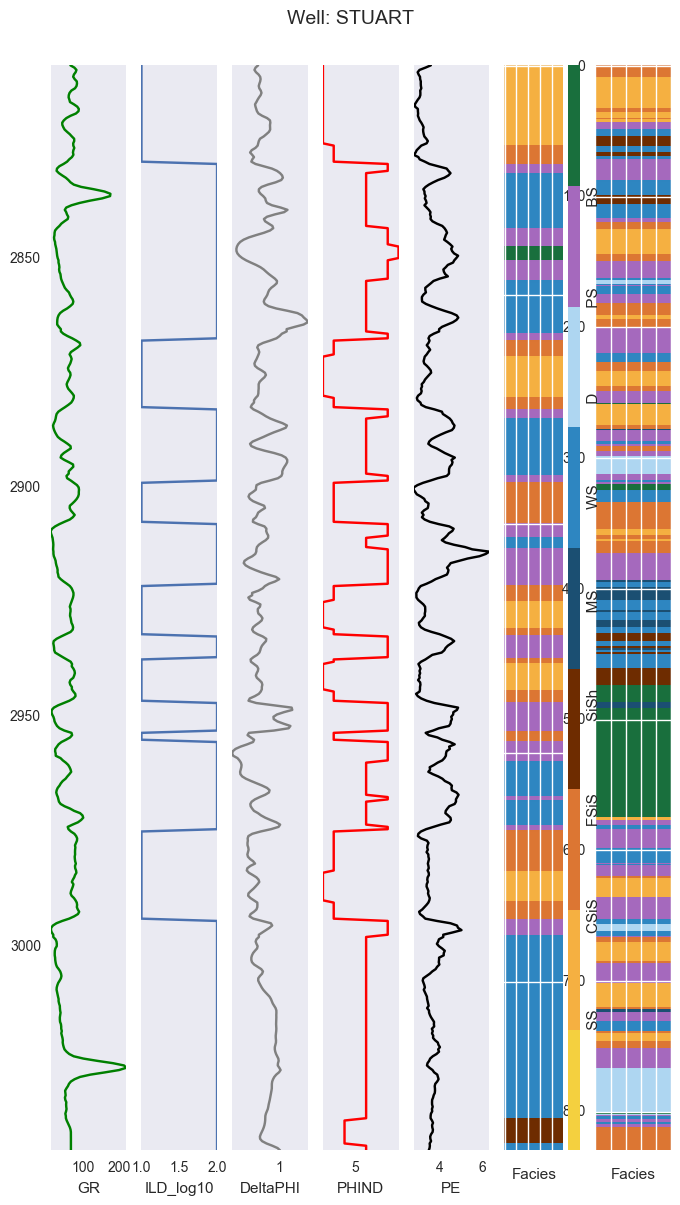

In [19]:
make_facies_log_plot(
    final_prediction[final_prediction['Well Name'] == 'STUART'],
    facies_colors, gcc_test)

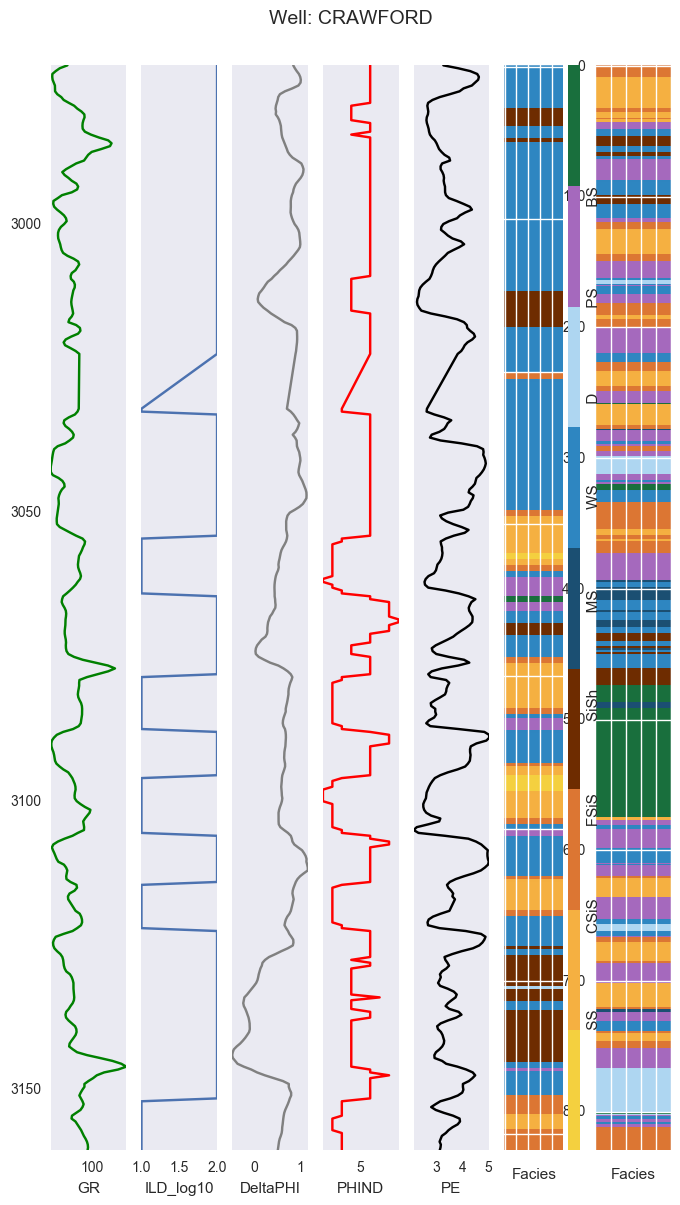

In [20]:
make_facies_log_plot(
    final_prediction[final_prediction['Well Name'] == 'CRAWFORD'],
    facies_colors, gcc_test)

In [18]:
def make_facies_log_plot(logs, facies_colors, comparison):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster1=np.repeat(np.expand_dims(comparison['Facies'].values,1), 100, 1)

    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(8, 14))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.NM_M, logs.Depth, '-')
    ax[2].plot(logs.ILD_log10, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.Facies  , logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    im=ax[6].imshow(cluster1, interpolation='none', aspect='auto',
                cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.NM_M.min(), logs.NM_M.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.Facies.min(),logs.Facies.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    plt.show()